<a href="https://colab.research.google.com/github/Merchan00/UndergraduateResearchWork/blob/main/Final_vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Red** de 28' de parámetros entrenada con 10k de datos, entrada de 128x128 y salida 128x128x1

Final final



# Inicializar colab, definir parametros de entrenamiento y ruta de datos

Modificacion de red neuronal de entrada 128x128x3 con un total de 28.000.000 parámetros entrenables. Se aplicará tecnica de fine-tuning con 10000 datos. batch_size = 16
epochs = 50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D
from tensorflow.keras.models import Model
import tensorflow as tf

width_shape, height_shape = 128, 128 # Tamaño de las imagenes de entrada
batch_size = 16
epochs = 50


In [ ]:
data_path_train="/content/drive/MyDrive/DATA_w_mask/train"
data_path_test="/content/drive/MyDrive/DATA_w_mask/test"
# obtenemos una lista con los archivos dentro de cada carpeta
data_list_train = os.listdir(data_path_train)
data_list_test = os.listdir(data_path_test)

# Funciones
*   Carga de datos
*   Gráfica de resultados de entrenamiento
*   MDC
*   Gráfica img,pred,label


In [ ]:
def umbral(img):
    aux=[]
    n,m,_=img.shape
    for i in range(n):
        for j in range(m):
            valu=img[i,j]
            if valu>0:
                aux.append(valu)

    va=np.mean(aux)
    return va

def umbral2(img,um):
    n,m,_=img.shape
    aux=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            valor=img[i,j]
            if valor>um:
                aux[i,j]=1
            else:
                pass

    return aux

def gris(img):
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    aux=imgGray
    
    return aux

def loaddata(data_list_train):

    Xtrain=[] 
    Ytrain=[]
    Xtest=[]
    orig_label=[]

    # Recorremos la carpeta train
    for folder in tqdm(data_list_train):
    #for i in range(10):
        #folder=data_list_train[i]
        
        # leemos cada imagen del dataset de entrenamiento y la redimensionamos
        name=data_path_train +"/"+folder+ '/image/' + folder+'.png'
        img = imread(name)[:,:,:3]  
        #img = gris(img)
        img = resize(img, (height_shape, width_shape),mode='constant', preserve_range=True)
        #img = img[:,:,None]
        # Agregamos cada imagen a la lista Xtrain
        Xtrain.append(img)
        #print("archivo:"+name)

        mask = data_path_train +"/"+folder+ '/masks/' + folder+'_mask.png'
        img2 = imread(mask)[:,:,:3]  
        img2 = gris(img2)
        img2 = resize(img2,(height_shape, width_shape),mode='constant', preserve_range=True)
        aux = img2[:,:,None] 
        orig_label.append(aux)
        val = umbral(aux)
        img2 = umbral2(aux,val)
        img2 = img2[:,:,None] 
        # Agregamos cada mascara a la lista Ytrain
        Ytrain.append(img2)

        #data_list_train = data_list_train1

    from sklearn.model_selection import train_test_split

    X_train, X_test, Y_train, Y_test = train_test_split(Xtrain,Ytrain,random_state=104, train_size=0.8, shuffle=True)

    print("\n")
    X_train = np.asarray(X_train,dtype=np.float32)
    print('Xtrain:',X_train.shape)

    Y_train = np.asarray(Y_train,dtype=np.float32)
    print('Ytrain:',Y_train.shape)

    X_test = np.asarray(X_test,dtype=np.float32)
    print('Xtest:',X_test.shape)

    Y_test = np.asarray(Y_test,dtype=np.float32)
    print('Ytest:',Y_test.shape)

    orig_label = np.asarray(orig_label,dtype=np.float32)

    X_train /=255
    #Y_train /=255
    X_test /=255
    #Y_test /=255
    orig_label/=255

    return X_train,Y_train,X_test,Y_test,orig_label

def gra_train(results):
    #results.history to see all keys 
    preci = results.history['precision']
    val_preci = results.history['val_precision']

    re_call = results.history['recall']
    val_re_call = results.history['val_recall']

    loss = results.history['loss']
    val_loss = results.history['val_loss']


    epochs_range = range(len(preci))

    fig, axs = plt.subplots(1,3, figsize=(20, 20))
    fig.suptitle("Metrics", fontsize=15)

    #Precision
    axs[0].plot(epochs_range, preci, label='Training Precision')
    axs[0].plot(epochs_range, val_preci, label='Validation Precision')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Training and Validation Precision')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Value')
    fig.suptitle("Metrics", fontsize=15)

    #Recall
    axs[1].plot(epochs_range, re_call, label='Training Recall')
    axs[1].plot(epochs_range, val_re_call, label='Validation Recall')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Training and Validation Recall')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Value')
    fig.suptitle("Metrics", fontsize=15)

    #loss
    axs[2].plot(epochs_range, loss, label='Training Loss')
    axs[2].plot(epochs_range,  val_loss, label='Validation Loss')
    axs[2].legend(loc='upper right')
    axs[2].set_title('Training and Validation Loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Value')


In [ ]:
import numpy as np

def multi_level_dice(img1, img2, n_levels):
    """
    Calcula el coeficiente de similitud de Dice de múltiples niveles para dos imágenes segmentadas.
    
    :param img1: Primera imagen segmentada
    :param img2: Segunda imagen segmentada
    :param n_levels: Número de niveles
    :return: Coeficiente de similitud de Dice de múltiples niveles
    """
    dice_levels = []
    weight_levels = []

    for i in range(n_levels):
        scale = 2 ** i
        img1_scale = img1[::scale, ::scale]
        img2_scale = img2[::scale, ::scale]

        intersection = np.logical_and(img1_scale, img2_scale)
        weight = np.sum(intersection) / (np.sum(img1_scale) + np.sum(img2_scale))
        weight_levels.append(weight)

        if weight == 0:
            dice = 0
        else:
            dice = 2 * np.sum(intersection) / (np.sum(img1_scale) + np.sum(img2_scale))
        dice_levels.append(dice)

    dice_multi_level = np.average(dice_levels, weights=weight_levels)

    if np.isnan(dice_multi_level)==True:
        return 0
    else:
        return dice_multi_level


In [ ]:
def plot_predict(image,predict,test):    
    fig, axs = plt.subplots(1,3,figsize=(20, 20) )
    axs = axs.flatten()

    axs[0].imshow(image, cmap="gray")
    axs[0].set_axis_off()
    axs[0].set_title('Image')
    
    axs[1].imshow(predict, cmap="gray")
    axs[1].set_axis_off()
    axs[1].set_title('Predict')

    axs[2].imshow(test, cmap="gray")
    axs[2].set_axis_off()
    axs[2].set_title('Label')



In [ ]:
def dice_coefficient(img1, img2):
    intersection = np.sum(np.logical_and(img1, img2))
    union = np.sum(np.logical_or(img1, img2))
    coefficient = 2 * intersection / (union + intersection)
    return coefficient

# Red

In [ ]:
Image_input = Input((height_shape, width_shape,3))
Image_in = Lambda(lambda x: x / 255)(Image_input)

def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters): 
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, (3, 3), padding="same", strides=2)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, (3, 3), padding="same", strides=1)(x)
    s = Conv2D(num_filters, (1,1), padding="same", strides=2)(inputs)
    x = x + s
    return x

def encoder_block_in(inputs, num_filters,strides):
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, (3, 3), padding="same", strides=strides)(x)
    
    return x
    
def encoder_block(inputs, num_filters):
    s1=encoder_block_in(inputs, num_filters,2)
    s2=encoder_block_in(inputs, num_filters,2)
    s3=encoder_block_in(s1, num_filters,1)
    x=s1+s2+s3
    return x
    
def decoder_block_in(inputs, num_filters):
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, (3, 3), padding="same", strides=1)(x)
    return x

def decoder_block(inputs, skip_features, num_filters):
    #x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([inputs, skip_features])
    s1=decoder_block_in(x, num_filters)
    s2=decoder_block_in(s1, num_filters)
    s3=decoder_block_in(x, num_filters)
    x=s1+s2+s3
    x = UpSampling2D((2, 2))(x)
    return x


def build_resunet(inputs):
    #inputs = Input(input_shape)
    print(inputs.shape)
    x=residual_block(inputs, 16)
    print("primer residual block")
    print(x.shape)   
    
    #Encoding        
    x0 = Conv2D(32, (3, 3), padding="same", strides=1)(x)
    print("Enco 0")
    print(x0.shape)

    x1=encoder_block(x0, 64)
    print("encoding 1")
    print(x1.shape)   
    
    x2=encoder_block(x1, 128)
    print("encoding 2")
    print(x2.shape)
    
        
    x3=encoder_block(x2, 256)
    print("encoding 3")
    print(x3.shape)
    
    x4=encoder_block(x3, 512)
    print("encoding 4")
    print(x4.shape)

    #Residualblock
    xx=residual_block(x4, 512)
    print("residual block btw")
    print(xx.shape)
    
    xx2=UpSampling2D((2, 2))(xx)
    print(xx2.shape)
    
    print("Decoding")
    #Decoding

    y0=decoder_block(xx2,x4, 512)
    print("dencoding 0")
    print(y0.shape)

    y=decoder_block(y0,x3, 256)
    print("dencoding 1")
    print(y.shape)

    y1=decoder_block(y,x2,128)
    print("dencoding 2")
    print(y1.shape)

    y2=decoder_block(y1,x1,64)
    print("dencoding 3")
    print(y2.shape)
    
    y3=decoder_block(y2,x0,32)
    print("dencoding 4")
    print(y3.shape)


    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(y3)
    print(outputs.shape)
    
    """ Model """
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', 
                  loss=['binary_crossentropy'], 
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           ])
    
    return model

if __name__ == "__main__":
    model = build_resunet(Image_in)
    model.summary() 

(None, 128, 128, 3)
primer residual block
(None, 64, 64, 16)
Enco 0
(None, 64, 64, 32)
encoding 1
(None, 32, 32, 64)
encoding 2
(None, 16, 16, 128)
encoding 3
(None, 8, 8, 256)
encoding 4
(None, 4, 4, 512)
residual block btw
(None, 2, 2, 512)
(None, 4, 4, 512)
Decoding
dencoding 0
(None, 8, 8, 512)
dencoding 1
(None, 16, 16, 256)
dencoding 2
(None, 32, 32, 128)
dencoding 3
(None, 64, 64, 64)
dencoding 4
(None, 128, 128, 32)
(None, 128, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 12

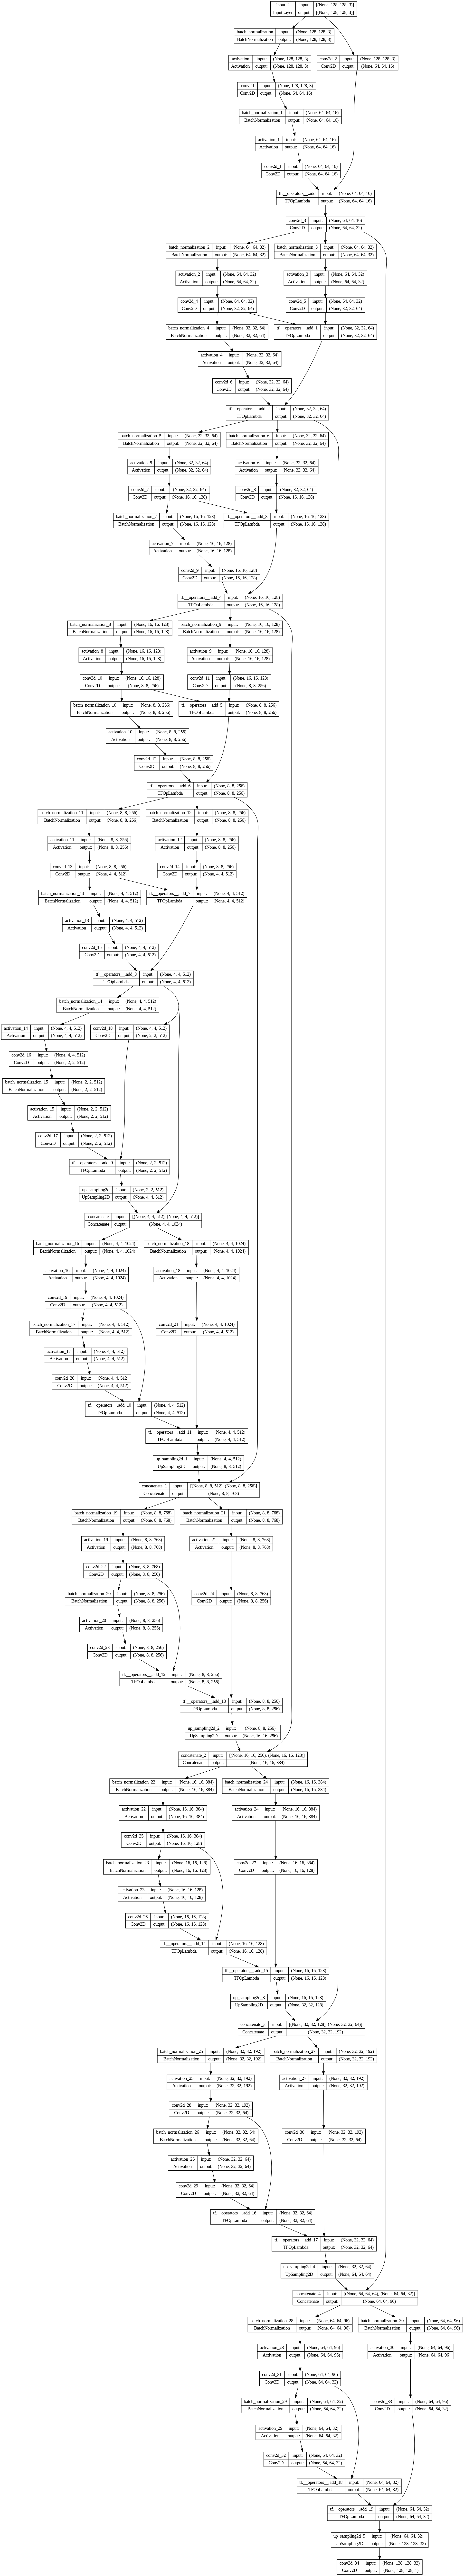

In [ ]:
from keras.utils import plot_model
plot_model(model,"model_v0.png",show_shapes=True)

# Cargar datos

In [ ]:
data_list_train2=data_list_train[:10000]
#len(data_list_train2)
X_train,Y_train,X_test,Y_test,OL=loaddata(data_list_train2)

  0%|          | 26/10000 [00:19<1:56:02,  1.43it/s]/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10000/10000 [1:58:36<00:00,  1.41it/s]




Xtrain: (8000, 128, 128, 3)
Ytrain: (8000, 128, 128, 1)
Xtest: (2000, 128, 128, 3)
Ytest: (2000, 128, 128, 1)


# Entrenamiento

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
#Modelcheckpoint
checkpoint_path = "final_vf/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
callback = [
            tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode="auto"),
            tf.keras.callbacks.TensorBoard(log_dir='logs')
            ]


results = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.1, 
                    batch_size=batch_size, 
                    epochs=40, 
                    validation_data=(X_test,Y_test),
                    callbacks=[callback])

Epoch 1/40
500/500 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9921 - precision: 0.5054 - recall: 0.2040
Epoch 1: saving model to final_vf/cp.ckpt
500/500 [==============================] - 335s 645ms/step - loss: 0.0249 - accuracy: 0.9921 - precision: 0.5054 - recall: 0.2040 - val_loss: 0.0221 - val_accuracy: 0.9927 - val_precision: 0.7560 - val_recall: 0.1189
Epoch 2/40
500/500 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9933 - precision: 0.6791 - recall: 0.2967
Epoch 2: saving model to final_vf/cp.ckpt
500/500 [==============================] - 316s 632ms/step - loss: 0.0183 - accuracy: 0.9933 - precision: 0.6791 - recall: 0.2967 - val_loss: 0.0173 - val_accuracy: 0.9936 - val_precision: 0.7487 - val_recall: 0.2966
Epoch 3/40
500/500 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9938 - precision: 0.7254 - recall: 0.3547
Epoch 3: saving model to final_vf/cp.ckpt
500/500 [==============================] 

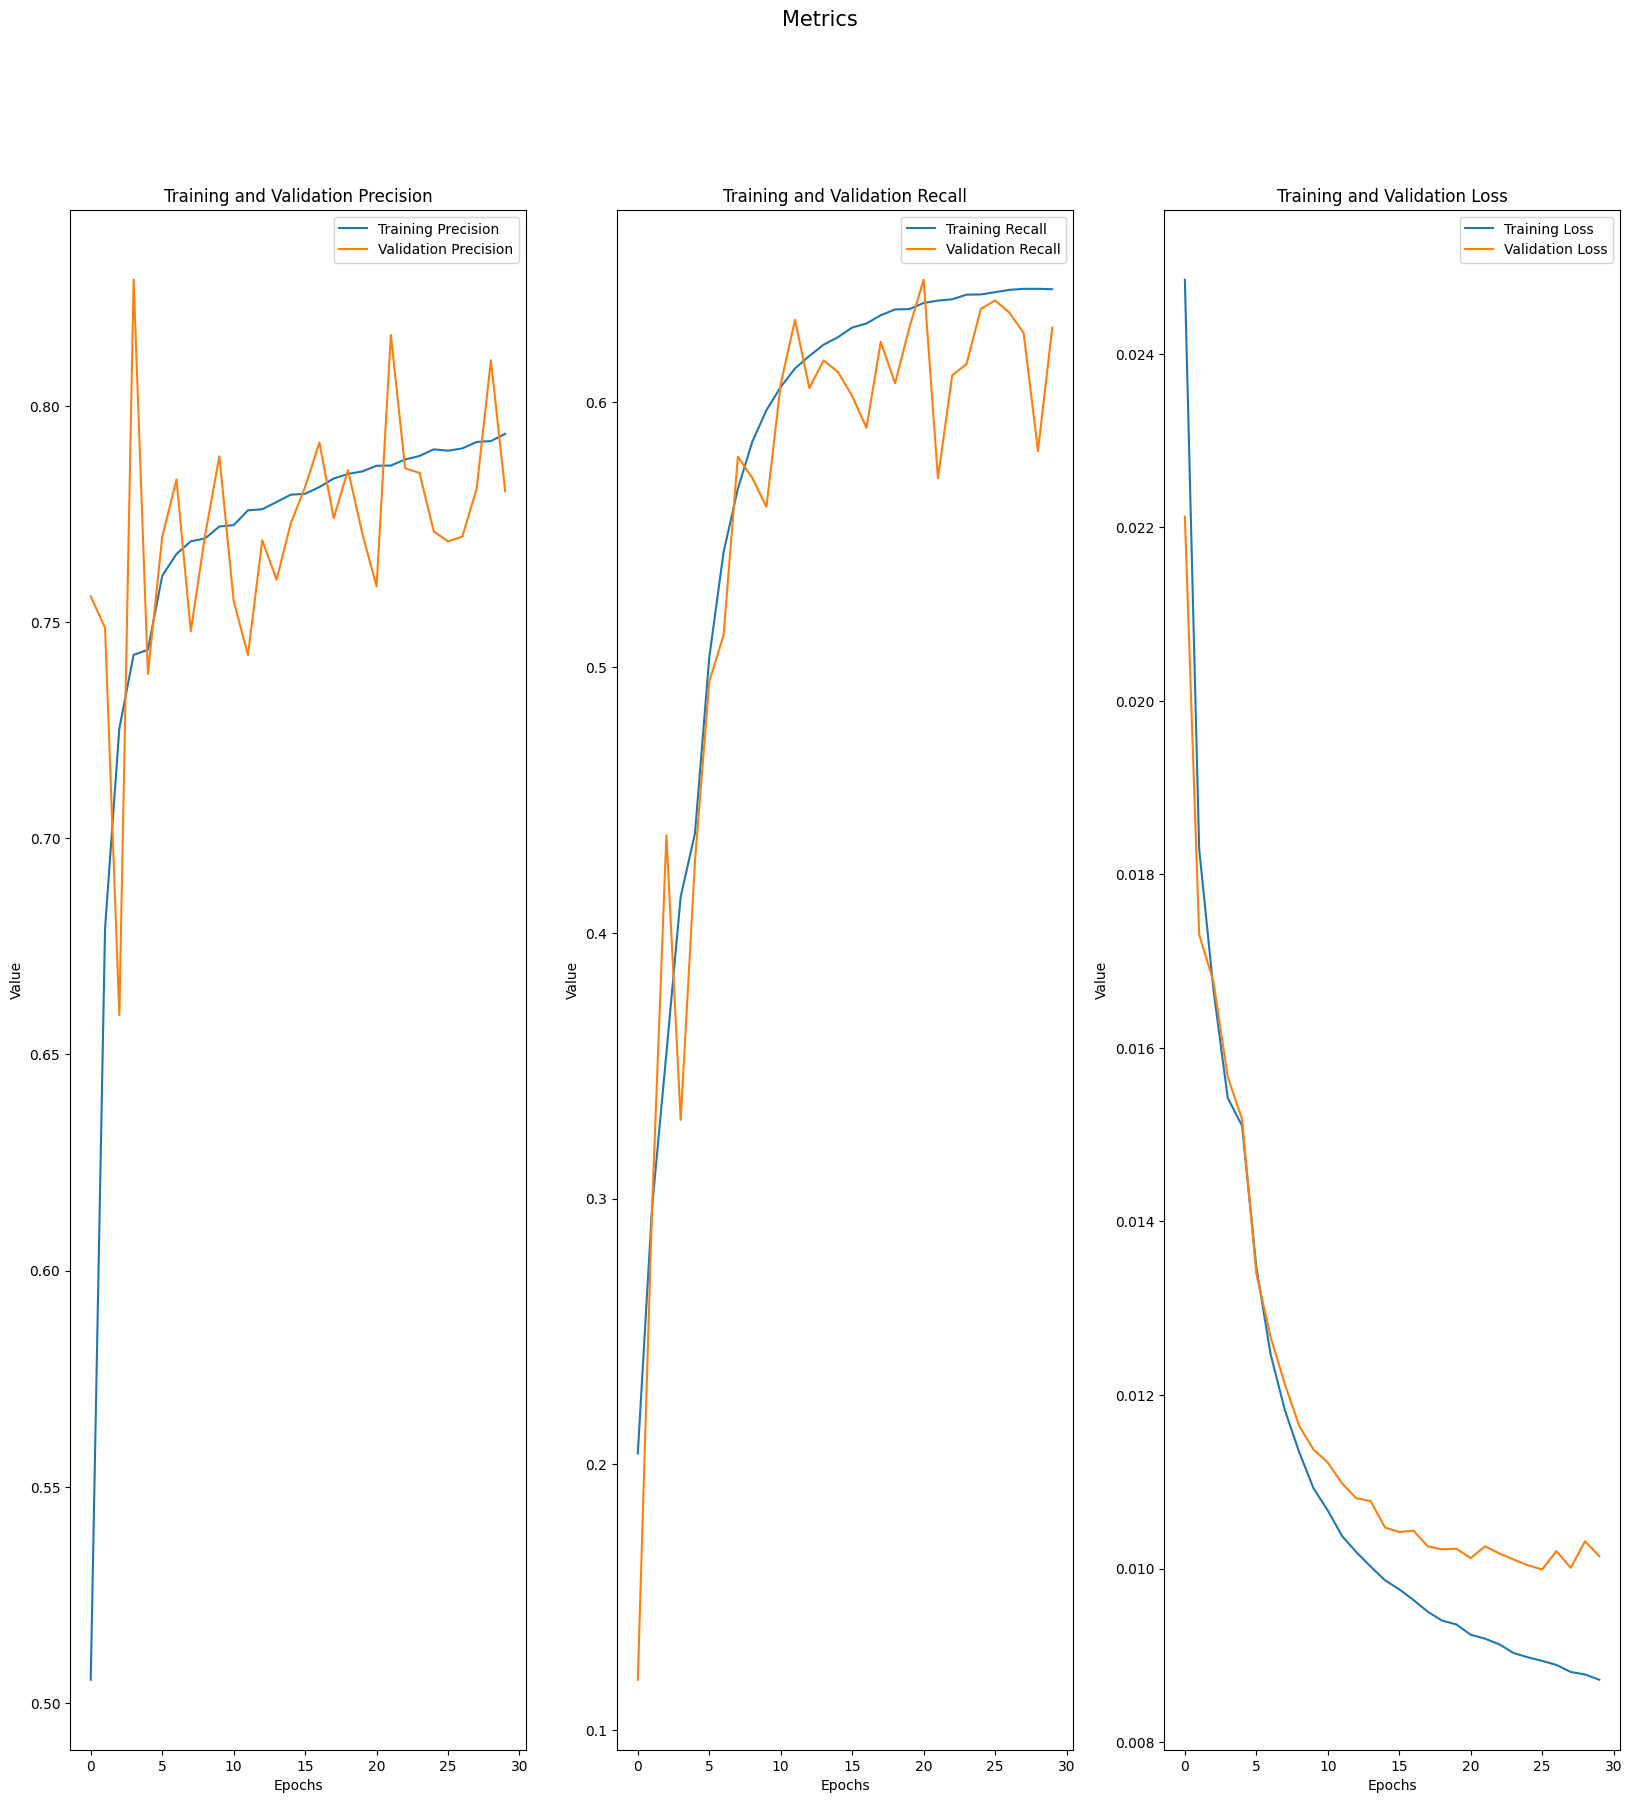

In [ ]:
gra_train(results)

In [ ]:
model.save('/content/drive/MyDrive/Universidad/CPS/Trabajo_de_Grado/Pulmonary/FASES/FASE_III/FINALDELOSFINALES/Final_vf.h5')

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.010142287239432335
Test accuracy: 0.9956305623054504


# Cargar el modelo entrenado


In [ ]:
from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/Universidad/CPS/Trabajo_de_Grado/Pulmonary/FASES/FASE_III/FINALDELOSFINALES/Final_vf.h5', compile=False)

In [ ]:
gg=len(my_model.layers)
for layer in my_model.layers[:gg]:
    layer.trainable = False

In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(my_model)

model2.compile(optimizer='adam', 
                loss=['binary_crossentropy'], 
                metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])

In [ ]:
score = model2.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.010142287239432335
Test accuracy: 0.9956305623054504


# Resultados entrenamiento

Para esta parte se visualiza aleatoriamente una imagen de entrenamiento con su respectiva predicción y label.

In [ ]:
import random

seed = 42
np.random.seed = seed

idx = random.randint(0, len(X_train))


preds_train = model2.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model2.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model2.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

63/63 [==============================] - 12s 176ms/step


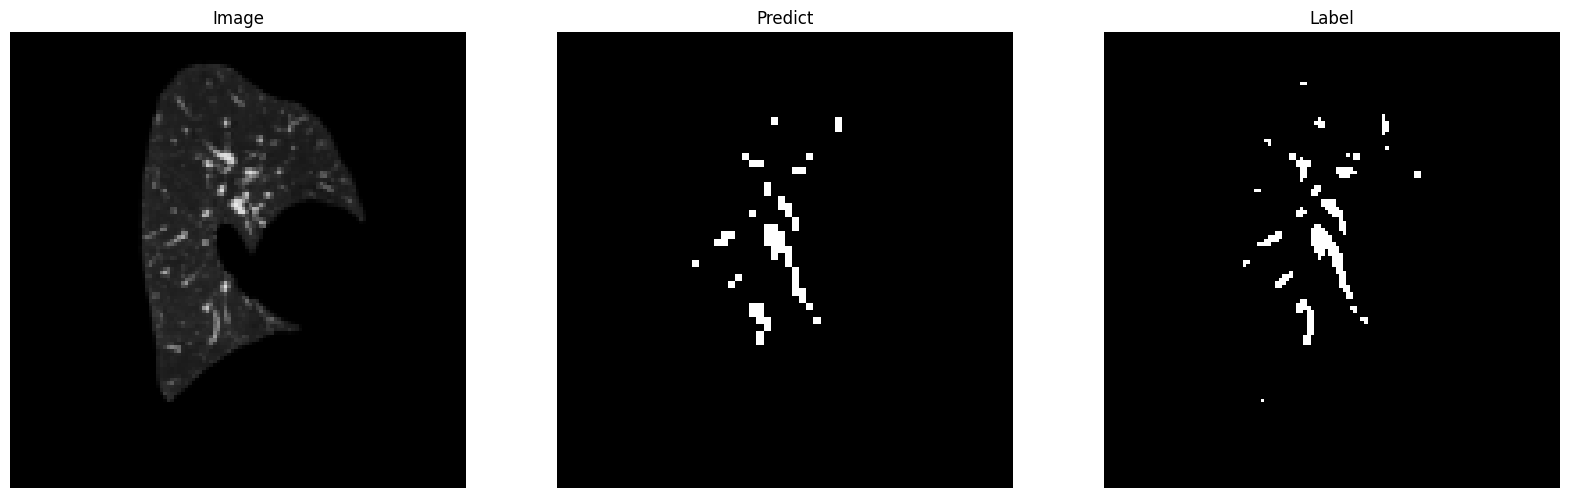

In [ ]:
ix = random.randint(0, len(preds_train_t))

plot_predict(X_train[ix],np.squeeze(preds_train_t[ix]),np.squeeze(Y_train[ix]))

In [ ]:
print("Coeff level dice:", multi_level_dice(np.squeeze(Y_train[ix]),np.squeeze(preds_train_t[ix]) , 2))

Coeff level dice: 0.743560334125237


____________________________________________________________________

**Para esta parte se realiza la predicción de acuerdo al modelo para las imágenes de TEST y se visualiza una imagen de test con su respectiva predicción y label con diferentes umbralizaciones.**

In [ ]:
preds_test2 = model2.predict(X_test, verbose=1)

63/63 [==============================] - 11s 173ms/step


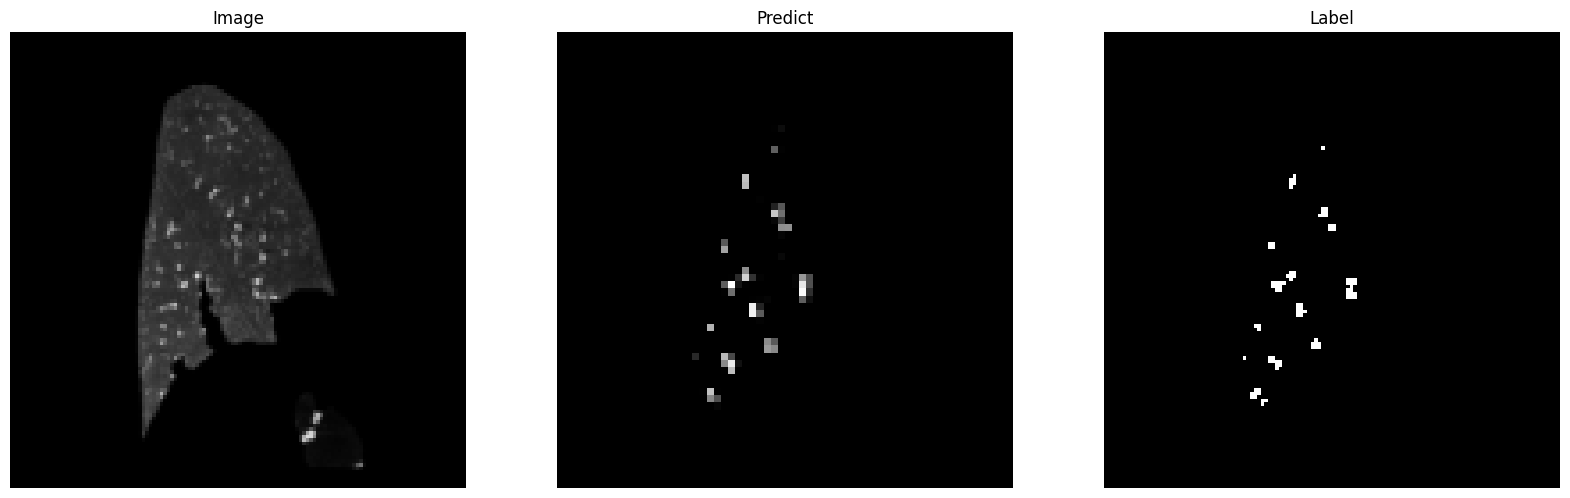

In [ ]:
preds_test_t3 = (preds_test2)
plot_predict(X_test[1120],preds_test_t3[1120],Y_test[1120])
#print("Coeff level dice:", multi_level_dice(np.squeeze(Y_test[1120]),np.squeeze(preds_test_t3[1120]) , 4))

Coeff dice: 0.6978723404255319


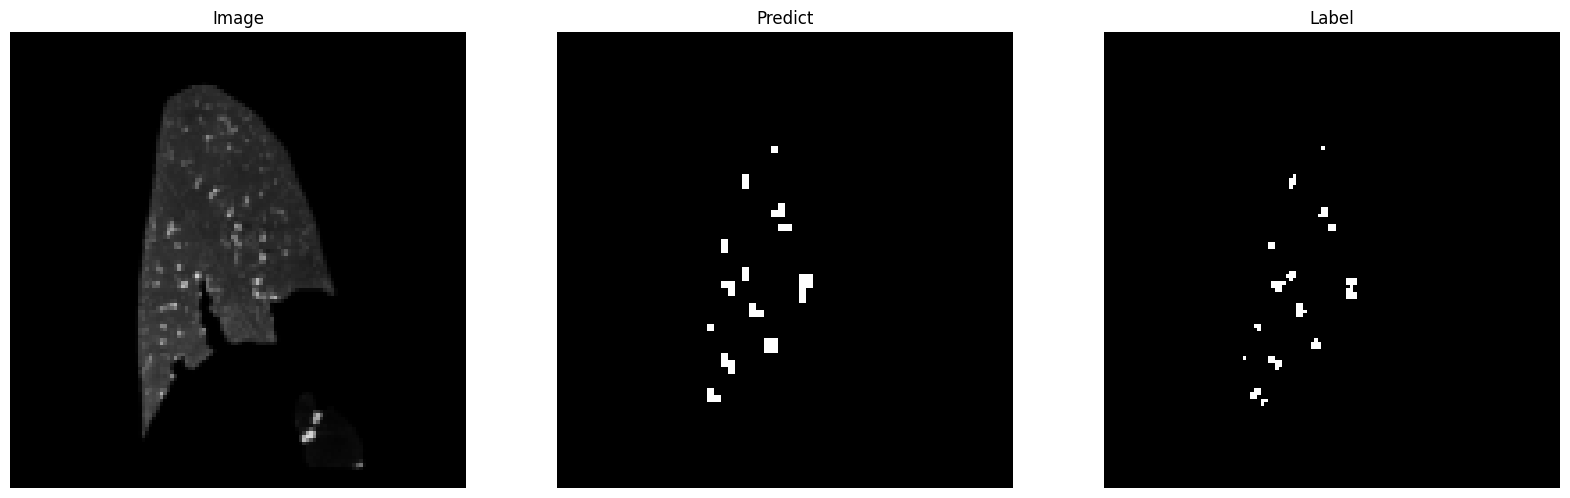

In [ ]:
#Aqui se cargar las anotaciones de test y se umbralizan
dd=1120
preds_test_t5 = (preds_test2)
pred_img=preds_test_t5[dd]
val=umbral(pred_img)
pred_img2=umbral2(pred_img,val)
pred_img2=pred_img2[:,:,]

OL2=preds_test_t5[dd]
OL2=OL2>0.3
img_test=(Y_test)
img_test2=img_test[dd]

test_img=X_test[dd]
plot_predict(test_img,OL2,img_test2)
print("Coeff dice:",dice_coefficient(OL2,img_test2))

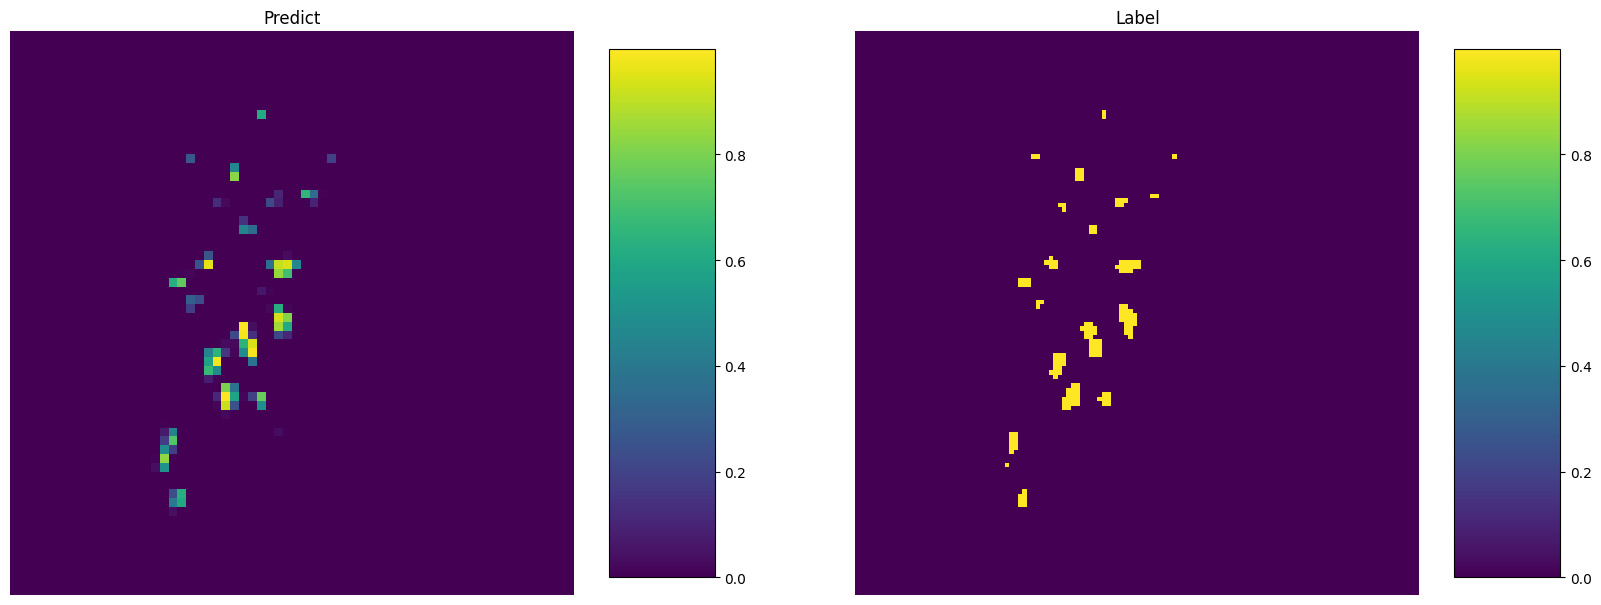

In [ ]:
import matplotlib as mpl

cmap = mpl.cm.cool
#plt.imshow(OL[1120],cmap=cmap)

fig, axs = plt.subplots(1,2,figsize=(20, 20) )
axs = axs.flatten()

a1=axs[0].imshow(pred_img)
axs[0].set_axis_off()
axs[0].set_title('Predict')
plt.colorbar(a1,ax=axs[0],aspect=5)

a2=axs[1].imshow(img_test2)
axs[1].set_axis_off()
axs[1].set_title('Label')
plt.colorbar(a1,ax=axs[1],aspect=5)

In [ ]:
val

0.009309547

In [ ]:
des=np.std(pred_img)
print(des)

0.060276777


Coeff dice: 0.6327272727272727


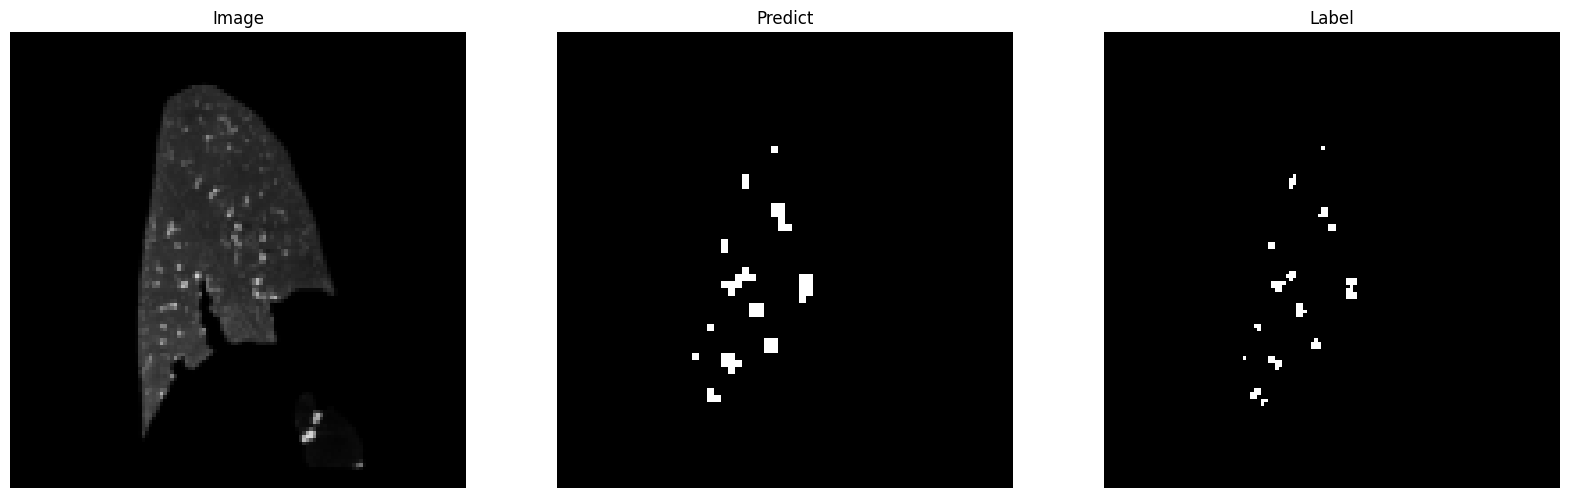

In [ ]:
OL3=preds_test_t5[dd]
OL3=OL3>des
plot_predict(test_img,OL3,img_test2)
print("Coeff dice:",dice_coefficient(OL3,img_test2))

In [ ]:
import math

def std_deviation(image):
    # Obtener el tamaño de la imagen
    height, width,_ = image.shape

    # Calcular la media de los valores de los píxeles
    pixel_sum = 0
    pixel_count = 0
    for y in range(height):
        for x in range(width):
            if image[y, x]>np.min(image):
                pixel_sum += image[y, x]
                pixel_count += 1
    pixel_mean = pixel_sum / pixel_count

    # Calcular la desviación estándar de los valores de los píxeles
    pixel_var = 0
    for y in range(height):
        for x in range(width):
            if image[y, x] > np.min(image):
                pixel_var += (image[y, x] - pixel_mean) ** 2
    pixel_std_dev = math.sqrt(pixel_var / pixel_count)

    print(pixel_count)
    return pixel_std_dev

In [ ]:
des_v2=std_deviation(pred_img)
print(des_v2)

16380
0.06028653324890151


In [ ]:
np.min(pred_img) 

2.0995848e-33

In [ ]:
MLD=np.zeros((int(X_test.shape[0]),8))
for i in range(int(X_test.shape[0])):
    for z in range(8):
        try:    
            value=multi_level_dice(np.squeeze(img_test[i]),np.squeeze(preds_test_t[i]) , z)
            if value!="NaN":
                MLD[i,z]=value
            else:
                MLD[i,z]=0 
        except:
            pass   
    MLD[i,z]=np.max(MLD[i,:])

MLD=np.delete(MLD,0,axis=1)         

In [ ]:
import pandas as pd
g2=pd.DataFrame(MLD)

In [ ]:
g2

In [ ]:
np.max(MLD[:,-1])

In [ ]:
np.mean(MLD[:,-1])

In [ ]:
headlist=["Nivel1","Nivel2","Nivel3","Nivel4","Nivel5","Nivel6","Mejor"]
g2.columns=headlist

In [ ]:
g2

In [ ]:
g2.drop(g2[  (g2['Nivel1'] ==0.0) ].index, inplace=True)

g2

In [ ]:
np.mean(list(g2.iloc[:, -1]))

In [ ]:
np.max(list(g2.iloc[:, -1]))

In [ ]:
np.min(list(g2.iloc[:, -1]))

In [ ]:
ex=g2.index
posmax=ex[[i for i, e in enumerate(list(g2.iloc[:, -1])) if e == np.max(list(g2.iloc[:, -1]))]]

In [ ]:
posmax[0]

In [ ]:
va=posmax[0]
plot_predict(X_test[va],np.squeeze(preds_test_t5[va]),np.squeeze(img_test[va]))
print("Coeff level dice:", multi_level_dice(np.squeeze(img_test[va]),np.squeeze(preds_test_t5[va]) , 4))
print("Coeff dice:",dice_coefficient(np.squeeze(img_test[va]), np.squeeze(preds_test_t5[va])))